In [200]:
import pandas as pd
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
import gc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch_sparse
from torchdiffeq import odeint
# from torchdiffeq import odeint_adjoint as odeint # Might be more stable according to docs of torchdiffeq
from torch_geometric.utils.num_nodes import maybe_num_nodes
from torch_geometric.utils import add_remaining_self_loops
from torch_scatter import scatter_add

import numpy as np
import networkx as nx

import time

from torch_geometric.datasets import Planetoid
from pathlib import Path

In [3]:
opt = {
  'data_norm': 'rw',
  'self_loop_weight': 1.0,
  'hidden_dim': 80,
  'input_dropout': 0.5,
  'dropout': 0.046878964627763316,
  'optimizer': 'adam',
  'lr': 0.01,
  'decay': 0.00507685443154266,
  'epoch': 100,
  'alpha': 1.0,
  'block': 'constant',
  'function': 'laplacian',
  'time': 18.294754260552843,
  'method': 'euler',
  'step_size': 1,
  'adjoint': False,
  'tol_scale': 821.9773048827274,
  'max_nfe': 2000,
  'no_early': True,
}

In [4]:
# Set torch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

## Get Dataset

In [5]:
dataset_dir = Path('data')
dataset_dir = dataset_dir.absolute()
if not dataset_dir.exists():
    dataset_dir.mkdir(parents=True)

dataset = Planetoid(dataset_dir, 'Cora')

# Some info
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
data = dataset.data
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of graphs: 1
Number of features: 1433
Number of classes: 7
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [6]:
# # Plot the graph
# G = nx.Graph()
#
# G.add_nodes_from(list(range(data.num_nodes)))
# G.add_edges_from([tuple(x) for x in data.edge_index.T.tolist()])
# nx.draw(G)
# plt.gca().set_facecolor('white')

In [7]:
# Train the given model on the given graph for num_epochs
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    x = data.x
    y = data.y.squeeze()

    # Set up the loss and the optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    out = model(x)

    loss = loss_fn(out[data.train_mask], y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

In [8]:
class LaplacianODEFunc(MessagePassing):

  # currently requires in_features = out_features
  def __init__(self, in_features, out_features, opt, data, device):
    super(MessagePassing, self).__init__()
    self.opt = opt
    self.device = device
    self.edge_index = None
    self.edge_weight = None
    self.attention_weights = None
    self.alpha_train = nn.Parameter(torch.tensor(0.0))
    self.beta_train = nn.Parameter(torch.tensor(0.0))
    self.x0 = None
    self.nfe = 0
    self.alpha_sc = nn.Parameter(torch.ones(1))
    self.beta_sc = nn.Parameter(torch.ones(1))
    self.in_features = in_features
    self.out_features = out_features
    self.w = nn.Parameter(torch.eye(opt['hidden_dim']))
    self.d = nn.Parameter(torch.zeros(opt['hidden_dim']) + 1)
    self.alpha_sc = nn.Parameter(torch.ones(1))
    self.beta_sc = nn.Parameter(torch.ones(1))

  def sparse_multiply(self, x):
    ax = torch_sparse.spmm(self.edge_index, self.edge_weight, x.shape[0], x.shape[0], x)
    return ax

  def forward(self, t, x):  # the t param is needed by the ODE solver.
    self.nfe += 1
    ax = self.sparse_multiply(x)
    alpha = torch.sigmoid(self.alpha_train)
    f = alpha * (ax - x)
    f = f + self.beta_train * self.x0
    return f

In [9]:
def get_rw_adj(edge_index, edge_weight=None, norm_dim=1, fill_value=0., num_nodes=None, dtype=None):
  # Not sure what this does yet, but it is necessary
  num_nodes = maybe_num_nodes(edge_index, num_nodes)

  if edge_weight is None:
    edge_weight = torch.ones((edge_index.size(1),), dtype=dtype,
                             device=edge_index.device)

  if not fill_value == 0:
    edge_index, tmp_edge_weight = add_remaining_self_loops(
      edge_index, edge_weight, fill_value, num_nodes)
    assert tmp_edge_weight is not None
    edge_weight = tmp_edge_weight

  row, col = edge_index[0], edge_index[1]
  indices = row if norm_dim == 0 else col
  deg = scatter_add(edge_weight, indices, dim=0, dim_size=num_nodes)
  deg_inv_sqrt = deg.pow_(-1)
  edge_weight = deg_inv_sqrt[indices] * edge_weight if norm_dim == 0 else edge_weight * deg_inv_sqrt[indices]
  return edge_index, edge_weight

In [10]:
class ConstantODEblock(nn.Module):
  def __init__(self, odefunc, opt, data, device, t=torch.tensor([0, 1])):
    super(ConstantODEblock, self).__init__()
    self.opt = opt
    self.t = t

    self.odefunc = odefunc(opt['hidden_dim'], opt['hidden_dim'], opt, data, device)
    edge_index, edge_weight = get_rw_adj(data.edge_index, edge_weight=data.edge_attr, norm_dim=1,
                                                                   fill_value=opt['self_loop_weight'],
                                                                   num_nodes=data.num_nodes,
                                                                   dtype=data.x.dtype)
    self.odefunc.edge_index = edge_index.to(device)
    self.odefunc.edge_weight = edge_weight.to(device)

    self.train_integrator = odeint
    self.test_integrator = odeint
    self.set_tol()

  def set_x0(self, x0):
    self.odefunc.x0 = x0.clone().detach()

  def set_tol(self):
    self.atol = self.opt['tol_scale'] * 1e-7
    self.rtol = self.opt['tol_scale'] * 1e-9

  def reset_tol(self):
    self.atol = 1e-7
    self.rtol = 1e-9

  def set_time(self, time):
    self.t = torch.tensor([0, time]).to(self.device)

  def forward(self, x):
    t = self.t.type_as(x)
    integrator = self.train_integrator if self.training else self.test_integrator
    func = self.odefunc
    state = x
    state_dt = integrator(
      func, state, t,
      method='euler',
      options=dict(step_size=self.opt['step_size']),
      atol=self.atol,
      rtol=self.rtol)
    z = state_dt[1]
    return z

  def __repr__(self):
    return self.__class__.__name__ + '( Time Interval ' + str(self.t[0].item()) + ' -> ' + str(self.t[1].item()) \
           + ")"

In [11]:
class GNN(MessagePassing):
  def __init__(self, opt, dataset, device=torch.device('cpu')):
    super(MessagePassing, self).__init__()
    self.opt = opt
    self.T = opt['time']
    self.num_classes = dataset.num_classes
    self.num_features = dataset.data.num_features
    self.num_nodes = dataset.data.num_nodes
    self.device = device

    self.m1 = nn.Linear(self.num_features, opt['hidden_dim'])
    self.hidden_dim = opt['hidden_dim']
    self.m2 = nn.Linear(opt['hidden_dim'], dataset.num_classes)
    self.f = LaplacianODEFunc
    block = ConstantODEblock
    time_tensor = torch.tensor([0, self.T]).to(device)
    self.odeblock = block(self.f, opt, dataset.data, device, t=time_tensor).to(device)

  def getNFE(self):
    return self.odeblock.odefunc.nfe

  def resetNFE(self):
    self.odeblock.odefunc.nfe = 0

  def reset(self):
    self.m1.reset_parameters()
    self.m2.reset_parameters()

  def forward(self, x, pos_encoding=None):
    x = F.dropout(x, self.opt['input_dropout'], training=self.training)
    x = self.m1(x)

    self.odeblock.set_x0(x)
    z = self.odeblock(x)

    # Activation.
    z = F.relu(z)

    # Dropout.
    z = F.dropout(z, self.opt['dropout'], training=self.training)

    # Decode each node embedding to get node label.
    z = self.m2(z)
    return z

In [12]:
def print_model_params(model):
  print(model)
  for name, param in model.named_parameters():
    if param.requires_grad:
      print(name)
      print(param.data.shape)

In [13]:
def set_train_val_test_split(
        seed: int,
        data: Data,
        num_development: int = 1500,
        num_per_class: int = 20) -> Data:
  rnd_state = np.random.RandomState(seed)
  num_nodes = data.y.shape[0]
  development_idx = rnd_state.choice(num_nodes, num_development, replace=False)
  test_idx = [i for i in np.arange(num_nodes) if i not in development_idx]

  train_idx = []
  rnd_state = np.random.RandomState(seed)
  for c in range(data.y.max() + 1):
    class_idx = development_idx[np.where(data.y[development_idx].cpu() == c)[0]]
    train_idx.extend(rnd_state.choice(class_idx, num_per_class, replace=False))

  val_idx = [i for i in development_idx if i not in train_idx]

  def get_mask(idx):
    mask = torch.zeros(num_nodes, dtype=torch.bool)
    mask[idx] = 1
    return mask

  data.train_mask = get_mask(train_idx)
  data.val_mask = get_mask(val_idx)
  data.test_mask = get_mask(test_idx)

  return data

In [123]:
@torch.no_grad()
def test(model, data, opt=None):  # opt required for runtime polymorphism
  model.eval()
  logits, accs = model(data.x), []
  for _, mask in data('train_mask', 'val_mask', 'test_mask'):
    pred = logits[mask].max(1)[1]
    acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
    accs.append(acc)
  return accs

In [ ]:
def print_training_stats(training_time_per_repeat, best_training_errors_per_repeat,
                         best_test_errors_per_repeat, best_validation_errors_per_repeat):
  print(f'Training time was: {training_time_per_repeat.mean():.2f}s +- {training_time_per_repeat.std():.2f}s')
  print(f'Best training error: {best_training_errors_per_repeat.max():.4f} \n'
        f'Best validation error: {best_validation_errors_per_repeat.max():.4f} \n'
        f'Best test error: {best_test_errors_per_repeat.max():.4f}')

In [263]:
def plot_train_test_val_errors(training_errors, test_errors, validation_errors, title='Forward Euler error - Cora dataset'):
  # Create dataframe for plotting
  n_repeats, n_epochs = training_errors.shape
  epoch_column = np.repeat(np.arange(0, n_epochs), n_repeats)
  epoch_column = np.tile(epoch_column, 3) # for the three types of errors
  training_error_columns = training_errors.flatten(order='F')
  test_error_columns = test_errors.flatten(order='F')
  validation_error_columns = validation_errors.flatten(order='F')
  errors = np.concatenate([training_error_columns, test_error_columns, validation_error_columns])
  error_type = np.concatenate([np.repeat(['Training'], n_epochs*n_repeats),
                               np.repeat(['Test'], n_epochs*n_repeats),
                               np.repeat(['Validation'], n_epochs*n_repeats)])


  numpy_array = np.stack([epoch_column, errors, error_type], axis=1)
  df_error = pd.DataFrame(numpy_array, columns=['epoch', 'error', 'error_type'])
  df_error.error = df_error.error.astype('float')
  df_error.epoch = df_error.epoch.astype('int')

  # Plot
  fig, ax = plt.subplots(figsize=(10,5))
  sns.lineplot(data=df_error, x='epoch', y='error', hue='error_type', ci='sd', ax=ax)
  ax.set_title(title, fontsize=20)
  ax.set_xlabel('Epoch', fontsize=16)
  ax.set_ylabel('Relative Error', fontsize=16)
  ax.legend(title='Error type', fontsize=16, title_fontsize=16)
  ax.tick_params(axis='both', which='major', labelsize=16)

In [230]:
data = set_train_val_test_split(42, dataset.data, num_per_class=50)
dataset.data = data

In [257]:
def train_NN(n_epochs, n_repeats, dataset, opt, device, net_class):
  training_errors = np.zeros([n_repeats, n_epochs])
  test_errors = np.zeros([n_repeats, n_epochs])
  validation_errors = np.zeros([n_repeats, n_epochs])
  training_time = np.zeros(n_repeats)
  best_training_errors = np.zeros(n_repeats)
  best_test_errors = np.zeros(n_repeats)
  best_validation_errors = np.zeros(n_repeats)

  for j in range(n_repeats):
    start_time = time.time()
    data = dataset.data.to(device)
    model = net_class(opt, dataset, device).to(device)
    parameters = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(parameters, lr=opt['lr'], weight_decay=opt['decay'])
    best_time = best_epoch = train_acc = val_acc = test_acc = 0

    this_test = test
    for i, epoch in enumerate(range(1, opt['epoch']+1)):

      loss = train(model, optimizer, data)
      tmp_train_acc, tmp_val_acc, tmp_test_acc = this_test(model, data, opt)

      training_errors[j, i] = tmp_train_acc
      test_errors[j, i] = tmp_test_acc
      validation_errors[j, i] = tmp_val_acc

      best_time = opt['time']
      if tmp_val_acc > val_acc:
        best_epoch = epoch
        train_acc = tmp_train_acc
        val_acc = tmp_val_acc
        test_acc = tmp_test_acc
        best_time = opt['time']

      # del loss
      # del tmp_train_acc
      # del tmp_val_acc
      # del tmp_test_acc
      # torch.cuda.empty_cache()
      # gc.collect()

    print('best val accuracy {:03f} with test accuracy {:03f} at epoch {:d} and best time {:03f}'.format(val_acc, test_acc, best_epoch, best_time))
    best_training_errors[j] = train_acc
    best_test_errors[j] = test_acc
    best_validation_errors[j] = val_acc
    end_time = time.time()
    training_time[j] = end_time-start_time

  return training_errors, test_errors, validation_errors, training_time, best_training_errors, best_test_errors, best_validation_errors

n_repeats = 20
n_epochs = opt['epoch']



training_errors, test_errors, validation_errors, training_time, best_training_errors, best_test_errors, best_validation_errors = train_NN(n_epochs, n_repeats, dataset, opt, device, GNN)

best val accuracy 0.855652 with test accuracy 0.865066 at epoch 66 and best time 18.294754


KeyboardInterrupt: 

In [239]:
print_training_stats(training_time, best_training_errors, best_test_errors, best_validation_errors)

Training time was: 4.17s +- 0.15s
Best training error: 0.9543 
Best validation error: 0.8678 
Best test error: 0.8584


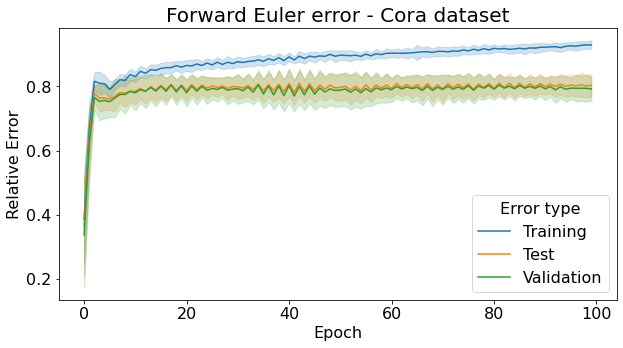

In [240]:
plot_train_test_val_errors(training_errors, test_errors, validation_errors)

In [16]:
# Train the given model on the given graph for num_epochs
def train_standard_GCN(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    y = data.y.squeeze()

    # Set up the loss and the optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    out = model(data)

    loss = loss_fn(out[data.train_mask], y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

In [ ]:
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    x = data.x
    y = data.y.squeeze()

    # Set up the loss and the optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    out = model(x)

    loss = loss_fn(out[data.train_mask], y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

In [17]:
@torch.no_grad()
def test_standard_GCN(model, data, opt=None):  # opt required for runtime polymorphism
  model.eval()
  logits, accs = model(data), []
  for _, mask in data('train_mask', 'val_mask', 'test_mask'):
    pred = logits[mask].max(1)[1]
    acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
    accs.append(acc)
  return accs

In [259]:
class Net(torch.nn.Module):
    def __init__(self, opt, dataset, device=torch.device('cpu')):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, opt['hidden_dim'])
        self.conv2 = GCNConv(opt['hidden_dim'], dataset.num_classes)
        self.edge_index = dataset.data.edge_index

    def forward(self, x):
      edge_index = self.edge_index

      x = self.conv1(x, edge_index)
      x = F.relu(x)
      x = F.dropout(x, training=self.training)
      x = self.conv2(x, edge_index)

      return F.log_softmax(x, dim=1)

In [265]:
n_repeats = 100
n_epochs = opt['epoch']
net_class = Net


training_errors, test_errors, validation_errors, training_time, best_training_errors, best_test_errors, best_validation_errors = train_NN(n_epochs, n_repeats, dataset, opt, device, net_class)

best val accuracy 0.840000 with test accuracy 0.853477 at epoch 35 and best time 18.294754
best val accuracy 0.833043 with test accuracy 0.829470 at epoch 64 and best time 18.294754
best val accuracy 0.839130 with test accuracy 0.844371 at epoch 66 and best time 18.294754
best val accuracy 0.837391 with test accuracy 0.834437 at epoch 62 and best time 18.294754
best val accuracy 0.842609 with test accuracy 0.846854 at epoch 51 and best time 18.294754
best val accuracy 0.845217 with test accuracy 0.827815 at epoch 6 and best time 18.294754
best val accuracy 0.845217 with test accuracy 0.857616 at epoch 40 and best time 18.294754
best val accuracy 0.828696 with test accuracy 0.830298 at epoch 32 and best time 18.294754
best val accuracy 0.843478 with test accuracy 0.858444 at epoch 10 and best time 18.294754
best val accuracy 0.837391 with test accuracy 0.835265 at epoch 68 and best time 18.294754
best val accuracy 0.830435 with test accuracy 0.839404 at epoch 53 and best time 18.294754


In [266]:
print_training_stats(training_time, best_training_errors, best_test_errors, best_validation_errors)

Training time was: 0.59s +- 0.06s
Best training error: 0.9971 
Best validation error: 0.8539 
Best test error: 0.8667


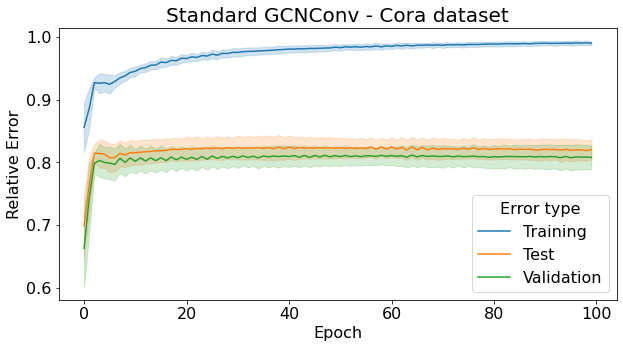

In [267]:
plot_train_test_val_errors(training_errors, test_errors, validation_errors, title='Standard GCNConv - Cora dataset')